# Python support library: `epic_kitchens`

We provide a support library `epic_kitchens` that is installed in your conda environment, this contains a variety of helper methods and scripts for...

* Gulping frames: `python -m epic_kitchens.gulp`
* Converting between RGB frame indices and Flow frame indices: `epic_kitchens.time.*`
* Dataset classes for use in training loops: `epic_kitchens.dataset.epic_dataset`

Find out more:

* [Github repo](https://github.com/epic-kitchens/epic-lib)
* [read the docs](http://epic-kitchens.readthedocs.io/en/latest/index.html)
* [PyPI package](https://pypi.org/project/epic-kitchens/)

---

# Loading frames 

We'll take a look at how you can load the frames off disk and query metadata of the frame segments using a package called [GulpIO](https://github.com/TwentyBN/GulpIO).

In [1]:
import numpy as np
from gulpio import GulpDirectory
from epic_kitchens.dataset.epic_dataset import EpicVideoDataset, EpicVideoFlowDataset, GulpVideoSegment
from pathlib import Path

## What is Gulp?

First we should take a little look at what [GulpIO](https://github.com/TwentyBN/GulpIO) is and what data is contained.

GulpIO consists of three main concepts: *ingestion*, *directories* and *chunks*. *Ingestion* is the process of 'Gulping' a dataset, i.e. transforming it from a set of individual image files on disk into a set of gulp *chunks* each containing a number of images and gulp *directories* containing both gulp *chunks* and metadata files.

At its core gulp concatenates image files into larger files (gulp chunks) and produces a metadata file containing the offsets and lengths of each image file inside the chunks.

![Gulp Chunk file structure](https://raw.githubusercontent.com/TwentyBN/GulpIO/master/docs/data_file_layout.png)

We recommend storing frames with gulp and our library `epic_kitchens` assumes this if you wish to use the dataset adapters provided.

When producing gulp files we can store arbitrary metadata associated with each segment, we store all information provided in the labels file (verb_class, noun_class, participant_id, ....) as well as details on the image itself: frame_size (width, height, channels) and the number of frames in the segment.

We provide dataset objects that make loading frames a little easier than with raw gulp from the `epic_kitchens` python package. 

In [2]:
gulp_root = Path('../data/processed/gulp')

In [3]:
# The EpicVideoDataset class encapsulates the logic for reading frames
# from a video and accessing the stored metadata about a segment
# The class_type determines the labels yielded by the dataset object.
# class_type value choices: ['verb', 'noun', 'verb+noun', None], None is 
# used for the test sets, where there are no labels.
class_type = 'verb+noun'
rgb_train = EpicVideoDataset(gulp_root / 'rgb_train', class_type)

The dataset objects give you access to the [GulpDirectory](https://github.com/TwentyBN/GulpIO#read-a-gulped-dataset). Which gives us access to all gulp metadata contained in the directory, we can see which segments are in the gulp file by inspecting the UIDs.

In [4]:
segment_uids = list(rgb_train.gulp_dir.merged_meta_dict.keys())
print(segment_uids[:10], "...")
print("Number of segments", len(segment_uids))

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'] ...
Number of segments 28472


Each entry in the `merged_meta_dict` has two keys, a `frame_info` key storing internal details about segment's frame locations and `meta_data`, arbitrary metadata we store when ingesting the frames, it is in this that we store details about the segment.

In [5]:
example_meta_entry = rgb_train.gulp_dir.merged_meta_dict[segment_uids[10]]
example_meta_entry.keys()

odict_keys(['frame_info', 'meta_data'])

In [6]:
# Frame info contains the byte offsets of each jpeg, the padding offset 
# and the length of the jpeg in the gulp chunk

# Format: (offset, padding, length) (all in bytes)

example_meta_entry['frame_info'][:10]

[[25991980, 0, 27348],
 [26019328, 1, 27412],
 [26046740, 3, 29040],
 [26075780, 1, 29372],
 [26105152, 1, 30944],
 [26136096, 1, 30944],
 [26167040, 3, 30988],
 [26198028, 3, 30656],
 [26228684, 3, 30832],
 [26259516, 2, 30900]]

Gulp stores the metadata dictionaries in a list, however there is only ever one dictionary for each segment

In [7]:
example_meta_entry['meta_data'][0]

OrderedDict([('participant_id', 'P01'),
             ('video_id', 'P01_01'),
             ('narration', 'open drawer'),
             ('start_timestamp', '00:00:24.97'),
             ('stop_timestamp', '00:00:26.20'),
             ('start_frame', 1498),
             ('stop_frame', 1572),
             ('verb', 'open'),
             ('verb_class', 2),
             ('noun', 'drawer'),
             ('noun_class', 9),
             ('all_nouns', ['drawer']),
             ('all_noun_classes', [9]),
             ('uid', 10),
             ('frame_size', [256, 456, 3]),
             ('num_frames', 74)])

# Reading frames

You don't have to deal with fiddling around with any of these details as we wrap them up in `GulpVideoSegment` objects that encapsulate the access to segment metadata including the number of frames and labels. You should work with these.

In [8]:
example_segment = rgb_train.video_segments[10]
example_segment

GulpVideoSegment(OrderedDict([('participant_id', 'P01'), ('video_id', 'P01_01'), ('narration', 'open drawer'), ('start_timestamp', '00:00:24.97'), ('stop_timestamp', '00:00:26.20'), ('start_frame', 1498), ('stop_frame', 1572), ('verb', 'open'), ('verb_class', 2), ('noun', 'drawer'), ('noun_class', 9), ('all_nouns', ['drawer']), ('all_noun_classes', [9]), ('uid', 10), ('frame_size', [256, 456, 3]), ('num_frames', 74)]), <function <lambda> at 0x7fb2dd6366a8>)

We can load all the frames for a segment:

In [9]:
example_frames = rgb_train.load_frames(example_segment)

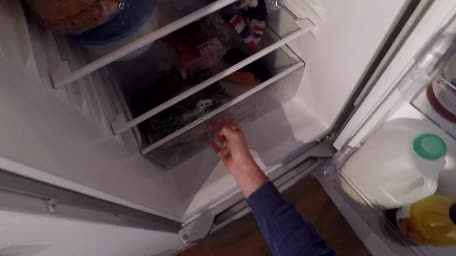

In [10]:
example_frames[0]

Frames are loaded as [PIL Images](https://pillow.readthedocs.io/en/5.1.x/reference/Image.html#the-image-class)

In [11]:
type(example_frames[0])

PIL.Image.Image

Which can be easily converted to numpy arrays

In [12]:
np.array(example_frames[0]).shape

(256, 456, 3)

And what is the label of this segment?

In [13]:
example_segment.label

{'verb': 2, 'noun': 9}

If we wished to access other metadata using dot notation

In [14]:
example_segment.verb

'open'

In [15]:
example_segment.noun

'drawer'

or indexing notation

In [16]:
example_segment['verb']

'open'

In [17]:
example_segment['noun']

'drawer'

Or access the metadata dictionary directly

In [18]:
example_segment.metadata

OrderedDict([('participant_id', 'P01'),
             ('video_id', 'P01_01'),
             ('narration', 'open drawer'),
             ('start_timestamp', '00:00:24.97'),
             ('stop_timestamp', '00:00:26.20'),
             ('start_frame', 1498),
             ('stop_frame', 1572),
             ('verb', 'open'),
             ('verb_class', 2),
             ('noun', 'drawer'),
             ('noun_class', 9),
             ('all_nouns', ['drawer']),
             ('all_noun_classes', [9]),
             ('uid', 10),
             ('frame_size', [256, 456, 3]),
             ('num_frames', 74)])

Once the frames are loaded, [moviepy](https://zulko.github.io/moviepy/) can be used to inspect the segments

In [19]:
!pip install moviepy

You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [20]:
from moviepy.editor import ImageSequenceClip
segment_clip = ImageSequenceClip([np.array(frame) for frame in example_frames], fps=60)
segment_clip.ipython_display()

100%|██████████| 75/75 [00:00<00:00, 644.71it/s]


---

Flow can be dealt with similarly as we provide an `EpicVideoFlowDataset` class sharing the same API as `EpicVideoDataset`

In [21]:
flow_train = EpicVideoFlowDataset(gulp_root / 'flow_train', class_type)

In [22]:
example_flow_frames = flow_train.load_frames(example_segment, range(0, example_segment.num_frames))

Flow frames are stored in alternate $(u, v)$ pairs, all $u$ frames have an even index, whereas $v$ frames have an odd index, so if $g$ is the set of frames in the gulp segment:

$$
\begin{align}
u_t &= g_{2t} \\
v_t &= g_{2t + 1}
\end{align}
$$

In [23]:
def grey_to_rgb(frames):
    """
    Convert frame(s) from gray (2D array) to RGB (3D array)
    """
    n_channels = 3
    return np.repeat(np.array(frames)[..., np.newaxis], n_channels, axis=-1)


def stitch_flow_uv_frames(uv_frames, width_axis=2):
    """
    Destack (u, v) frames and concatenate them side by side for display purposes
    """
    u_frames = np.array(uv_frames[::2])
    v_frames = np.array(uv_frames[1::2])
    stacked_frames = np.concatenate((u_frames, v_frames), axis=width_axis)
    return stacked_frames


def clipify_flow(frames, fps=30):
    """
    Destack flow frames, join them side by side and then create an ImageSequenceClip
    for display
    """
    frames = grey_to_rgb(stitch_flow_uv_frames(list(map(np.array, frames))))
    segment_clip = ImageSequenceClip(list(frames), fps=fps)
    return segment_clip

In [24]:
example_segment = flow_train.video_segments[10]
# Note you can also pass an iterable of frame indices to extract, this is useful for
# methods like TSN which only need a few frames
example_flow_frames =  flow_train.load_frames(example_segment, range(0, example_segment.num_frames))
clipify_flow(example_flow_frames).ipython_display()

100%|██████████| 38/38 [00:00<00:00, 330.65it/s]
